In [6]:
################################
#                         
# Finding correlation between 
# two background subtracted
# Fermi light curves
# Or Swift-BAT lightcurves
#
# Date 27 Sept 2019 
# Version 1.0
# Vikas Chand
# Date 12 June 2021
# Version 2.0
# Addition: Swift BAT
################################



# Import required python modules



from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from astropy.io import ascii
import time
import progressbar

In [7]:
# Define a function calculating discrete cross-correlation function
# defined in Band D. L.. , ApJ , 1997, vol. 486 pg. 928 


def transient_crosscorr(x_b_subtracted, y_b_subtracted, t):


    """x_b_subtracted is the RATE of first lightcurve,
    y_b_subtracted is the RATE of second lightcurve and
    t is the timestamps of the input series assumed equal in number for both
    
    Return: offsets and cross-correlations at those offsets"""
    
    # the step size of the input lighcurve
    
    tstep = t[1]-t[0]
    
    # number of datapoints in the lightcurve
    
    N = len(t)
    
    # offset k*tstep will be from -t_min to t_max
    
    lag_k = np.arange(-N, N+1, 1)
    offset = lag_k*tstep
    
    
    
    # Finding denominator of DCCF
    den = np.sqrt(np.sum(np.square(x_b_subtracted))*np.sum(np.square(y_b_subtracted)))
    
    # Finding DCCF, (i-1) because of python indexing starts from 0
    ccf = [np.sum([x_b_subtracted[(i-1)]* y_b_subtracted[(i-1)+(k)] for i in range(max(1, 1-k), min(N, N-k)+1)])/den for k in range(-N, N+1)]
    
    # return offsets and CCFs
    return offset, ccf
    

#############################################
#fit an asymmetric
#Gaussian model to the CCF versus time-delay
#The method is used in Monthly Notices of the Royal
#Astronomical Society, Volume 446, Issue 2, 11 January 2015, 
#Pages 1129-1138, https://doi.org/10.1093/mnras/stu2153
#
#An asymmetric funtion is fit to the CCF to find the maximum and offset 
#corresponding to this maximum is the observed lag
############################################


#define assymetric Gaussian function

def Asymmetric_Gaussian(x, const, N, mu, sigma1, sigma2):
    
    """Constant + Asymmetric Gaussian function
    mean = mu, standard deviation = sigma1, sigma2"""
    
    
    m = []
    for i in range(len(x)):
        if x[i] < mu:
            AG = const + N*np.exp(-(((x[i]-mu)/(sigma1))**2)/2)
            m.append(AG)
        else:
            AG = const + N*np.exp(-(((x[i]-mu)/(sigma2))**2)/2)
            m.append(AG)
    return m
    

# Fit assymetric Gaussian function defined above to the CCF vs time-delay data
# Using Scipy CurveFit popt, pcov = curve_fit(line, x, y, sigma=e)


def Asymmetric_Gaussian_fit(func, off_set, cc_f, boundaries=None):
    
    if boundaries == None:
        popt, pcov = curve_fit(func, off_set, cc_f)
        
    else:
        popt, pcov = curve_fit(func, off_set, cc_f, bounds=boundaries)
        
    return popt, pcov





First series data length 467
Second series data length 467


 99% (9999 of 10000) |################## | Elapsed Time: 0:40:15 ETA:   0:00:00

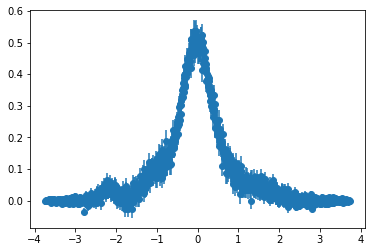

 99% (999 of 1000) |#################### | Elapsed Time: 0:10:14 ETA:   0:00:00

First Curve is leading by:  -0.08908151999635606 +-  0.013762895425381203


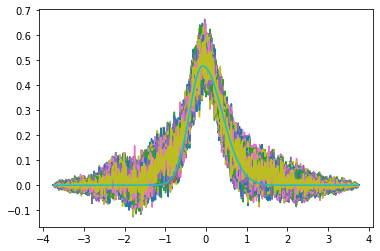

In [11]:
##MAIN PROGRAM
# Estimate correlation, lag and  error in lag


##############
#read data 
#X-data

#ifl = ascii.read('LC_n6_8ms150300.qdp', header_start = None, data_start=1, comment= '#')

GRB1 = ascii.read('8ms_lc_ascii.dat')

times_GRB1, LC1_GRB1, LC2_GRB1, LC3_GRB1, LC4_GRB1 = np.array(GRB1['col1']), np.array(GRB1['col2']), np.array(GRB1['col4']), np.array(GRB1['col6']), np.array(GRB1['col8'])
LC1_GRB1_err, LC2_GRB1_err, LC3_GRB1_err, LC4_GRB1_err = np.array(GRB1['col3']), np.array(GRB1['col5']), np.array(GRB1['col7']), np.array(GRB1['col9']) 

t0 =  times_GRB1
x0 =  LC1_GRB1
xerr0 = LC1_GRB1_err

#Generate random signs from normal distribution
random_nums = np.random.randn(len(t0))
random_signs = random_nums/abs(random_nums)


#start and stop times to calculate lags
tstart = -0.64
tstop = 10.0

#Trim the series to the range of start and stop times
source_range  = [(t0 >= tstart) & (t0 <= tstop)][0]
time_stamps_src_range = t0[source_range]


x = x0[source_range]
x_err = xerr0[source_range]

print('First series data length', len(x))

#Y-data

#ifl1 = ascii.read('LC_n6_8ms830.qdp', header_start = None, data_start=1, comment= '#')



t1 =  times_GRB1
y1 =  LC2_GRB1
yerr1 = LC2_GRB1_err



y = y1[source_range]
y_err = yerr1[source_range]

print('Second series data length', len(y))


#############
# Oserved Correlation

off_set_observed, cc_f_observed = transient_crosscorr(x, y, time_stamps_src_range) 
#print "Observed Correlation", off_set_observed, cc_f_observed

#############
# Finding error in CCF

# Add random noise to the input rate
# And find ccf vs lag 10000 times
# find ccf mean and standard deviation 
# The standard deviation of these values per time-delay bin
# is then assigned as the uncertainty in the original
# CCF values obtained from the real light curves.


t1 = time_stamps_src_range




# initialize an 10000 arays with time_stamps_src_range bins
offset_length = len(off_set_observed)
n_simul_ccf = 10000

A  = np.zeros_like([[0]*n_simul_ccf]*offset_length, dtype=float) # A[0] contains all n_simul_ccf elements


bar = progressbar.ProgressBar(max_value=n_simul_ccf)
for i in range(n_simul_ccf):
    # For Fermi data 
    #ynew = y + random_signs[source_range]*np.random.poisson(y_err)
    #xnew = x + random_signs[source_range]*np.random.poisson(x_err)
    
    # For Swift data
    ynew = y + np.random.randn(len(y_err))*y_err
    xnew = x + np.random.randn(len(x_err))*x_err
    
    
    
    off_set, cc_f = transient_crosscorr(xnew, ynew, t1)
    
    A.T[i] = cc_f
    
    time.sleep(0.1)
    bar.update(i)


# Find standard deviation of all A[i]s which are t_length in number
ccf_std_errs = [np.std(A[i]) for i in range(offset_length)]

plt.errorbar(off_set_observed, cc_f_observed, yerr=ccf_std_errs, fmt='o')
plt.show()

# Now we have both cc_f_observed and error in it which is ccf_std_errs
# Fit ccf and its std error as input but randomize the erros with standard normal distribution



nsimulations = 1000
lag = []

bar = progressbar.ProgressBar(max_value=nsimulations)
for i in range(nsimulations):
    ccfnew = cc_f_observed + np.random.randn(len(ccf_std_errs))*ccf_std_errs
    
    
    # fit asymmetric gaussian to correlation data

    #~ mu_estimate_min = np.abs(off_set[np.argmin(cc_f)])
    #~ mu_estimate_max = np.abs(off_set[np.argmax(cc_f)])
    
    sigma1_estimate = np.abs(np.max(off_set_observed))
    
    max_at = np.argmax(ccfnew)
    
    fit  = Asymmetric_Gaussian_fit(Asymmetric_Gaussian, off_set_observed[max_at-1000:max_at+2000], ccfnew[max_at-1000:max_at+2000], ([np.min(ccfnew), 0, -1, 0, 0], [0.5, np.inf,  1, np.inf, np.inf]))
    
    # fit parameters

    popt = fit[0]
    
    # generate a fine binning data set
    tinc = (off_set[1]-off_set[0])/100.0
    
    offset_refine = np.arange(min(off_set_observed), max(off_set_observed), tinc)
    
    AG_r = Asymmetric_Gaussian(offset_refine, *popt)
    #find the maximum of AG refined
    
    #plot the refined fits
    #~ plt.plot(off_set, cc_f)
    #~ plt.plot(offset_refine, AG_r )#- popt[0])

    max_ccf_r = np.argmax(AG_r)

    # print progress
    
    time.sleep(0.1)
    bar.update(i)

    #find offset corresponding to this index from refined offsets
    lag_this_run = offset_refine[max_ccf_r]
    lag.append(lag_this_run)
    
    plt.plot(off_set_observed, ccfnew)
    plt.plot(offset_refine, AG_r-popt[0])

    
    
    


# from lag distribution find errors in lag

lag_mean = np.mean(lag)
lag_error = np.std(lag)

print('First Curve is leading by: ', lag_mean, '+- ', lag_error)

plt.show()


In [ ]:
#band 1"15-25 keV"
#band 2 "25-50 keV"
#band 3 "50-100 keV"
#band 4 "100-350 keV"
#band 5 "15-350 keV"



# Results
# 8 ms
# 15-25 keV to 25-50 keV 
# -0.08908151999635606 +-  0.013762895425381203
# 15-25 keV 

